In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest, GradientBoostingClassifier
from sklearn.svm import SVC, OneClassSVM
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import stats
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import warnings
import os
warnings.filterwarnings('ignore')

In [5]:
# Setting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)



# Data Loading & Exploration

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Angaza - Capstone/final_merged_dataset.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,timestamp,accX,accY,accZ,gyroX,gyroY,gyroZ,activity
0,2025-04-07 17:32:46.916114,2.076372,5.324030,11.511869,-0.799623,0.226784,-0.802830,3
1,2025-04-08 00:16:36.513633,15.375001,12.498000,38.560951,-1.914550,-0.149875,1.730988,3
2,2025-04-08 12:19:16.873909,5.911284,-5.088951,2.312724,0.440029,1.061470,-1.245862,2
3,2025-04-07 17:33:36.893426,1.721038,0.486341,9.878170,-0.154396,-0.082161,0.765872,1
4,2025-04-07 22:49:04.675492,13.069597,-3.192025,-2.072184,0.925613,0.486554,-2.840216,3


In [7]:
np.random.seed(42)
activity_counts = df['activity'].value_counts().sort_index()
n_sample_per_activity = activity_counts.values.tolist()
print("n_sample_per_activity:", n_sample_per_activity)
total_samples = sum(n_sample_per_activity)
print("total_samples:", total_samples)

n_sample_per_activity: [8382, 8779, 9133, 8785]
total_samples: 35079


In [8]:
# Basic Info
print(f"Dataset shape: {df.shape}")
print(f"\nActivity distribution:")
print(df['activity'].value_counts().sort_index())
print(f"\nDataset info:")
print(df.info())
print(f"\nBasic statistics:")
print(df.describe())

Dataset shape: (35079, 8)

Activity distribution:
activity
0    8382
1    8779
2    9133
3    8785
Name: count, dtype: int64

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35079 entries, 0 to 35078
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  35079 non-null  datetime64[ns]
 1   accX       35079 non-null  float64       
 2   accY       35079 non-null  float64       
 3   accZ       35079 non-null  float64       
 4   gyroX      35079 non-null  float64       
 5   gyroY      35079 non-null  float64       
 6   gyroZ      35079 non-null  float64       
 7   activity   35079 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 2.1 MB
None

Basic statistics:
                           timestamp          accX          accY  \
count                          35079  35079.000000  35079.000000   
mean   2025-04-08 00:33:09.017913344      2.597176   

# Data Visualisation

In [9]:
activity_labels = {0: 'Standing', 1: 'Walking', 2: 'Shaking', 3: 'Jumping'}
df['activity_name'] = df['activity'].map(activity_labels)

✓ Saved: activity_distributions.png


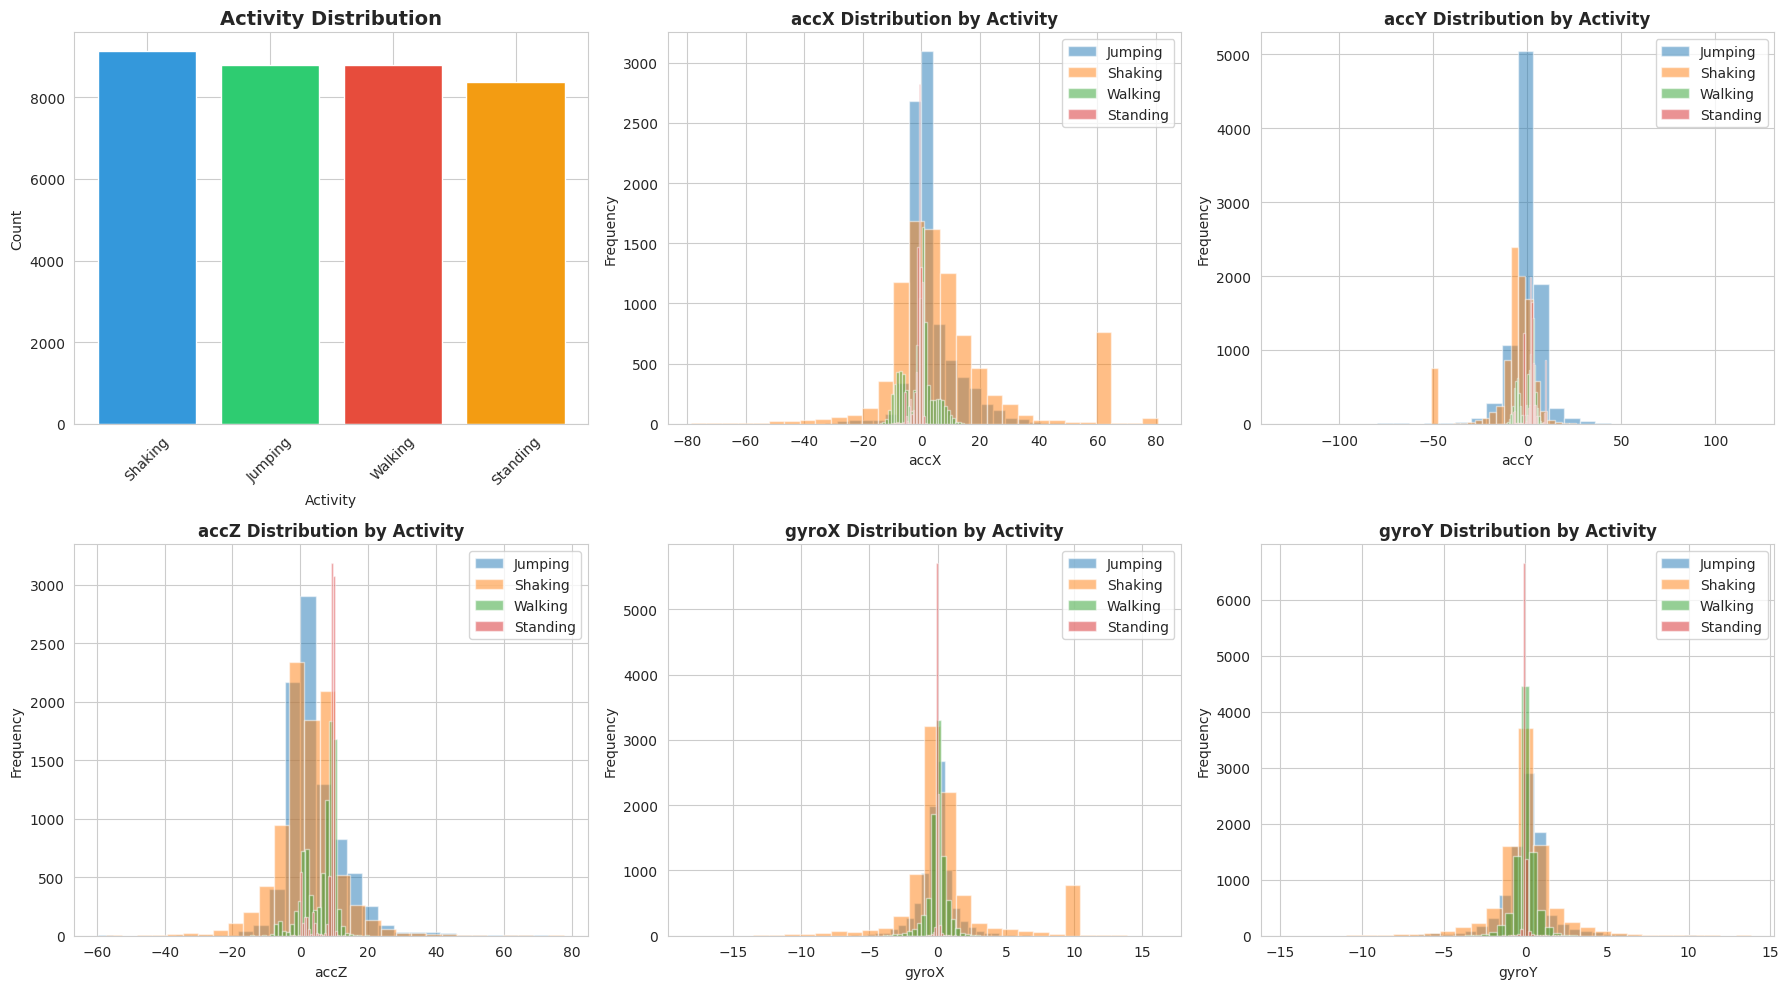

In [10]:
# Activity Distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

activity_counts = df['activity_name'].value_counts()
axes[0, 0].bar(activity_counts.index, activity_counts.values, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
axes[0, 0].set_title('Activity Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Activity')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Accelerometer data distribution
for i, axis_name in enumerate(['accX', 'accY', 'accZ']):
    ax = axes[0, 1] if i == 0 else axes[0, 2] if i == 1 else axes[1, 0]
    for activity in df['activity'].unique():
        data_subset = df[df['activity'] == activity][axis_name]
        ax.hist(data_subset, alpha=0.5, label=activity_labels[activity], bins=30)
    ax.set_title(f'{axis_name} Distribution by Activity', fontsize=12, fontweight='bold')
    ax.set_xlabel(axis_name)
    ax.set_ylabel('Frequency')
    ax.legend()

# Gyroscope data distribution
for i, axis_name in enumerate(['gyroX', 'gyroY', 'gyroZ']):
    ax = axes[1, 1] if i == 0 else axes[1, 2] if i == 1 else axes[0, 0]
    if i == 2:
        continue
    for activity in df['activity'].unique():
        data_subset = df[df['activity'] == activity][axis_name]
        ax.hist(data_subset, alpha=0.5, label=activity_labels[activity], bins=30)
    ax.set_title(f'{axis_name} Distribution by Activity', fontsize=12, fontweight='bold')
    ax.set_xlabel(axis_name)
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.savefig('activity_distributions.png', dpi=300, bbox_inches='tight')
print("✓ Saved: activity_distributions.png")
plt.show()

A bar chart shows the number of samples per activity.The dataset appears to be balanced, with roughly equal counts for all activities, around 8,000–9,000 samples each.

** Overall Interpretation **
- The dataset captures distinct motion patterns across different activities using both accelerometer and gyroscope sensors.
Shaking has the widest distributions across all axes showing highly dynamic movement.
Standing has the tightest, most centered distributions showing minimal motion.
Walking and Jumping fall in between, with some overlap in acceleration and rotation features.

✓ Saved: correlation_matrix.png


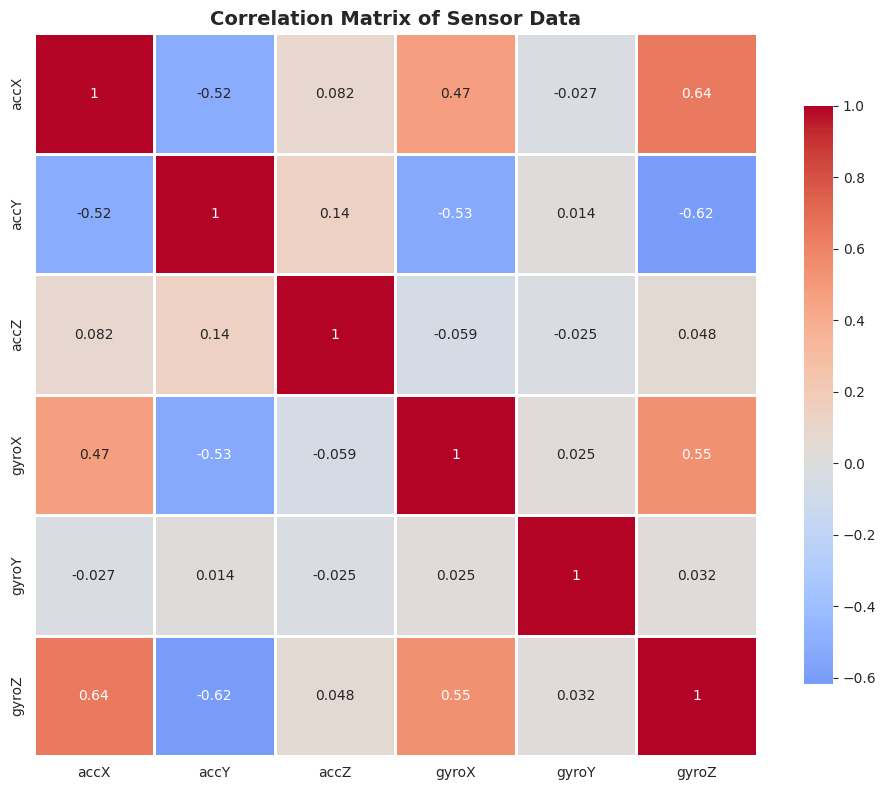

In [11]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))
correlation_matrix = df[['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=ax,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
ax.set_title('Correlation Matrix of Sensor Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Saved: correlation_matrix.png")
plt.show()

**Interpretation**
- The accelerometer and gyroscope readings capture complementary but partly overlapping signals of body motion.
X and Z axes show the most interdependence.
The mixture of positive and negative correlations indicates diverse motion patterns, confirming the richness of the sensor data for distinguishing activities.

✓ Saved: sensor_boxplots.png


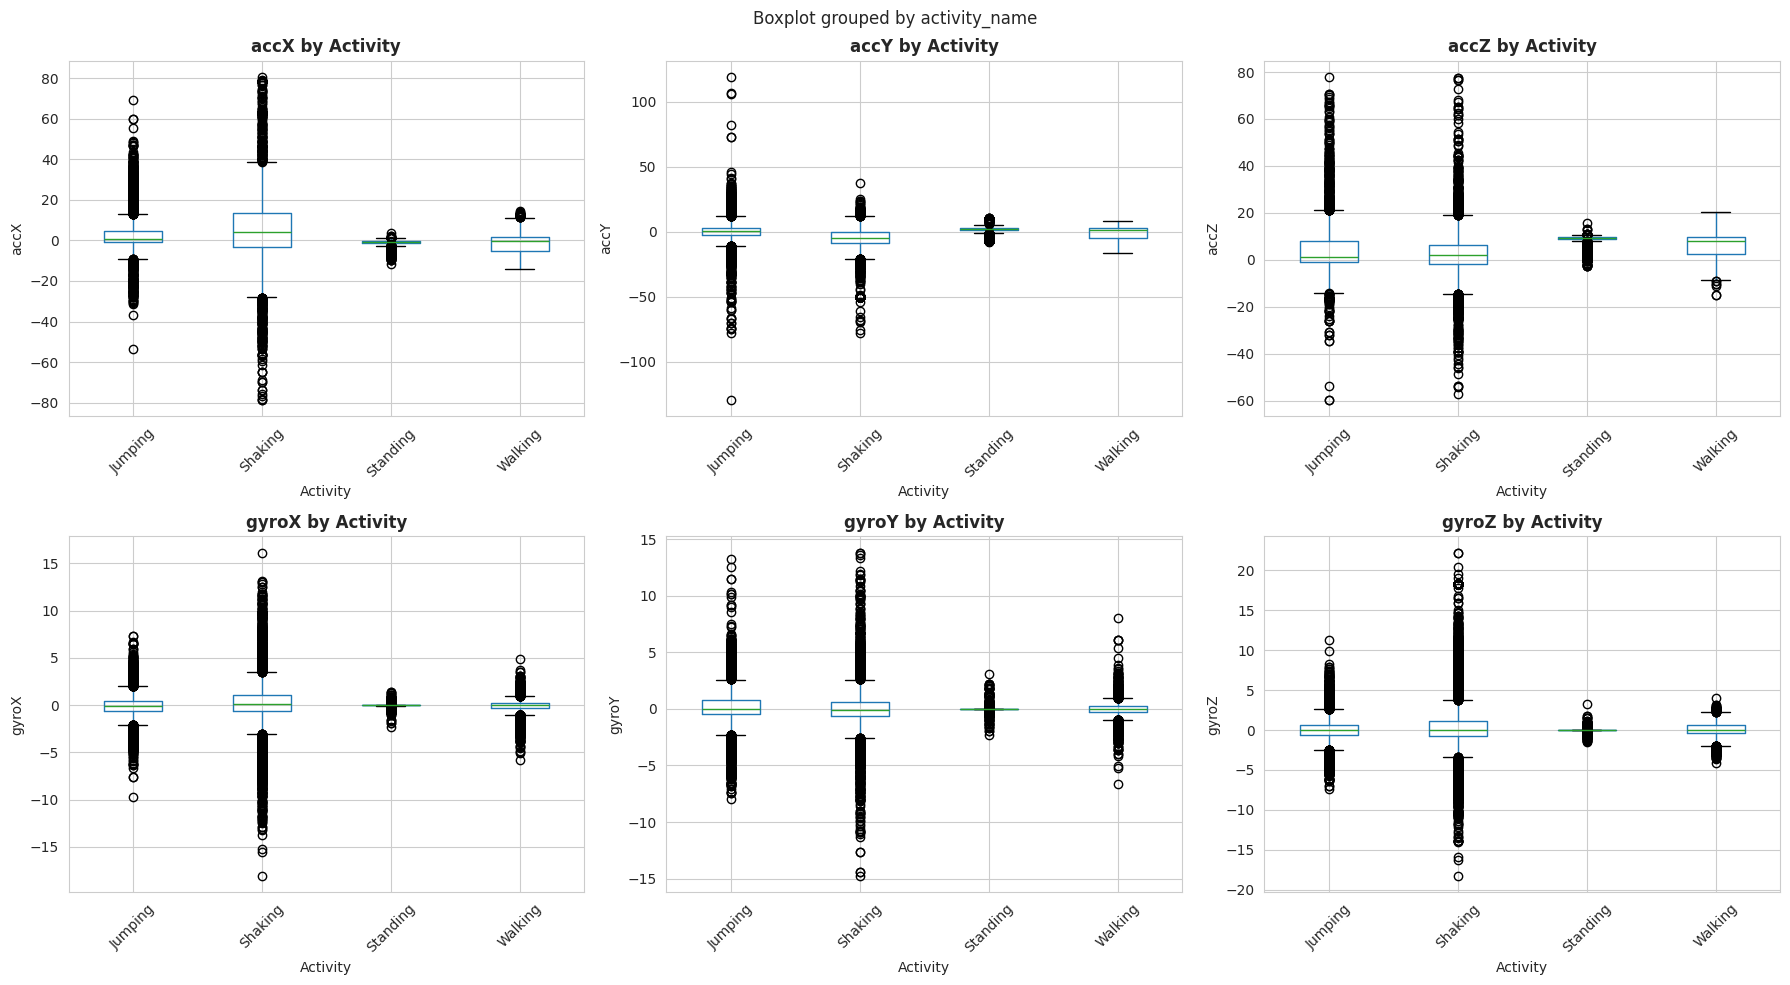

In [12]:
# Box Plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
sensor_cols = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ']

for idx, col in enumerate(sensor_cols):
    ax = axes[idx // 3, idx % 3]
    df.boxplot(column=col, by='activity_name', ax=ax)
    ax.set_title(f'{col} by Activity', fontsize=12, fontweight='bold')
    ax.set_xlabel('Activity')
    ax.set_ylabel(col)
    plt.sca(ax)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('sensor_boxplots.png', dpi=300, bbox_inches='tight')
print("✓ Saved: sensor_boxplots.png")
plt.show()

**Insights**
- Shaking produces the widest distribution and most outliers across all sensors,; it’s the most dynamic activity.
- Standing shows minimal variation, confirming its static nature.
- Jumping has large positive Z-axis acceleration values, matching upward motion patterns.
- Walking shows moderate but consistent movement across all axes, less extreme than jumping or shaking.

# Feature Engineering

In [13]:
def extract_features(data_segment, sampling_rate=9.07):
    """
    Extract comprehensive features from a data segment

    Features include:
    - Time domain: mean, std, min, max, range, RMS, IQR
    - Statistical: skewness, kurtosis
    - Motion: magnitude, jerk
    - Frequency domain: dominant frequency, spectral entropy
    """
    features = {}

    # Time domain features for each axis
    for col in ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ']:
        if col in data_segment.columns:
            values = data_segment[col].values
            features[f'{col}_mean'] = np.mean(values) if len(values) > 0 else 0
            features[f'{col}_std'] = np.std(values) if len(values) > 1 else 0
            features[f'{col}_min'] = np.min(values) if len(values) > 0 else 0
            features[f'{col}_max'] = np.max(values) if len(values) > 0 else 0
            features[f'{col}_range'] = (np.max(values) - np.min(values)) if len(values) > 0 else 0
            features[f'{col}_rms'] = np.sqrt(np.mean(values**2)) if len(values) > 0 else 0
            features[f'{col}_iqr'] = (np.percentile(values, 75) - np.percentile(values, 25)) if len(values) > 0 else 0
            features[f'{col}_skewness'] = stats.skew(values) if len(values) > 2 else 0
            features[f'{col}_kurtosis'] = stats.kurtosis(values) if len(values) > 3 else 0
            features[f'{col}_zcr'] = np.sum(np.diff(np.sign(values)) != 0) / len(values) if len(values) > 1 else 0

    acc_magnitude = np.sqrt(data_segment['accX']**2 + data_segment['accY']**2 + data_segment['accZ']**2)
    gyro_magnitude = np.sqrt(data_segment['gyroX']**2 + data_segment['gyroY']**2 + data_segment['gyroZ']**2)
    features['acc_magnitude_mean'] = np.mean(acc_magnitude) if len(acc_magnitude) > 0 else 0
    features['acc_magnitude_std'] = np.std(acc_magnitude) if len(acc_magnitude) > 1 else 0
    features['acc_magnitude_max'] = np.max(acc_magnitude) if len(acc_magnitude) > 0 else 0
    features['gyro_magnitude_mean'] = np.mean(gyro_magnitude) if len(gyro_magnitude) > 0 else 0
    features['gyro_magnitude_std'] = np.std(gyro_magnitude) if len(gyro_magnitude) > 1 else 0
    features['gyro_magnitude_max'] = np.max(gyro_magnitude) if len(gyro_magnitude) > 0 else 0

    acc_jerk = np.sqrt(np.diff(data_segment['accX'])**2 +
                       np.diff(data_segment['accY'])**2 +
                       np.diff(data_segment['accZ'])**2) if len(data_segment) > 1 else np.array([0])
    features['acc_jerk_mean'] = np.mean(acc_jerk) if len(acc_jerk) > 0 else 0
    features['acc_jerk_std'] = np.std(acc_jerk) if len(acc_jerk) > 1 else 0

    features['acc_xy_corr'] = np.corrcoef(data_segment['accX'], data_segment['accY'])[0, 1] if len(data_segment) > 1 else 0
    features['acc_xz_corr'] = np.corrcoef(data_segment['accX'], data_segment['accZ'])[0, 1] if len(data_segment) > 1 else 0
    features['acc_yz_corr'] = np.corrcoef(data_segment['accY'], data_segment['accZ'])[0, 1] if len(data_segment) > 1 else 0

    for col in ['accX', 'accY', 'accZ']:
        values = data_segment[col].values
        fft_vals = np.abs(fft(values))[:len(values)//2] if len(values) > 1 else np.array([0])
        fft_freqs = fftfreq(len(values), d=1/sampling_rate)[:len(values)//2] if len(values) > 1 else np.array([0])
        if len(fft_vals) > 1 and np.max(fft_vals[1:]) > 1e-3:
            dom_freq_idx = np.argmax(fft_vals[1:]) + 1
            features[f'{col}_dom_freq'] = fft_freqs[dom_freq_idx]
        else:
            features[f'{col}_dom_freq'] = 0
        psd = fft_vals ** 2
        psd_norm = psd / np.sum(psd) if np.sum(psd) > 0 else np.array([1])
        spectral_entropy = -np.sum(psd_norm * np.log2(psd_norm + 1e-10)) if len(psd_norm) > 0 else 0
        features[f'{col}_spectral_entropy'] = spectral_entropy

    return features

# Create time-based sliding windows
window_duration = pd.Timedelta(seconds=3)
window_step = pd.Timedelta(seconds=1.5)
min_samples_per_window = 5
features_list = []
labels_list = []

# Sort data by timestamp
df = df.sort_values('timestamp')

for activity in df['activity'].unique():
    activity_data = df[df['activity'] == activity]
    start_time = activity_data['timestamp'].min()
    end_time = activity_data['timestamp'].max()
    current_time = start_time
    while current_time + window_duration <= end_time:
        window = activity_data[
            (activity_data['timestamp'] >= current_time) &
            (activity_data['timestamp'] < current_time + window_duration)
        ]
        if len(window) >= min_samples_per_window and len(window['activity'].unique()) == 1:
            features = extract_features(window, sampling_rate=9.07)
            features_list.append(features)
            labels_list.append(window['activity'].iloc[0])
            print(f"Activity {activity}, Window {current_time}: {len(window)} samples")
        current_time += window_step

# Create features DataFrame
features_df = pd.DataFrame(features_list)
features_df['activity'] = labels_list

# Force unit conversion from g to m/s²
for col in ['accX', 'accY', 'accZ']:
    for feat in ['mean', 'std', 'min', 'max', 'range', 'rms', 'iqr']:
        features_df[f'{col}_{feat}'] *= 9.8
for feat in ['mean', 'std', 'max']:
    features_df[f'acc_magnitude_{feat}'] *= 9.8
    features_df[f'gyro_magnitude_{feat}'] *= 9.8
for feat in ['mean', 'std']:
    features_df[f'acc_jerk_{feat}'] *= 9.8

# Handle NaN or infinite values
features_df = features_df.replace([np.inf, -np.inf], np.nan)
features_df = features_df.fillna(features_df.mean(numeric_only=True))

# Map activities
activity_map = {0: 'Standing', 1: 'Walking', 2: 'Shaking', 3: 'Jumping'}
features_df['activity'] = features_df['activity'].map(activity_map)

print(f"Extracted features shape: {features_df.shape}")
print(f"Number of features: {len(features_df.columns) - 1}")
print(f"\nFeature names:")
print(features_df.columns.tolist()[:10], "... and more")
print(f"\nFeatures extracted and cleaned")
print(f"Final feature set size: {features_df.shape}")

# Check class balance
print("\nClass distribution:")
print(features_df['activity'].value_counts())

# Validate features
print("\nSample features:")
print(features_df[['accZ_mean', 'acc_magnitude_mean', 'acc_jerk_mean', 'acc_jerk_std', 'accX_dom_freq', 'accY_dom_freq', 'accZ_dom_freq', 'activity']].head(10))
print("\nFrequency-domain features by activity:")
print(features_df[['accX_dom_freq', 'accY_dom_freq', 'accZ_dom_freq', 'accX_spectral_entropy', 'accY_spectral_entropy', 'accZ_spectral_entropy', 'activity']].groupby('activity').mean())
print("\nFrequency-domain feature statistics:")
print(features_df[['accX_dom_freq', 'accY_dom_freq', 'accZ_dom_freq', 'activity']].groupby('activity').describe())

# Check Y-axis variability
print("\nY-axis standard deviation by activity:")
print(df.groupby('activity')['accY'].std())

Activity 0, Window 2025-04-07 17:18:42.543900: 30 samples
Activity 0, Window 2025-04-07 17:18:44.043900: 30 samples
Activity 0, Window 2025-04-07 17:18:45.543900: 30 samples
Activity 0, Window 2025-04-07 17:18:47.043900: 30 samples
Activity 0, Window 2025-04-07 17:18:48.543900: 30 samples
Activity 0, Window 2025-04-07 17:18:50.043900: 30 samples
Activity 0, Window 2025-04-07 17:18:51.543900: 30 samples
Activity 0, Window 2025-04-07 17:18:53.043900: 30 samples
Activity 0, Window 2025-04-07 17:18:54.543900: 30 samples
Activity 0, Window 2025-04-07 17:18:56.043900: 30 samples
Activity 0, Window 2025-04-07 17:18:57.543900: 30 samples
Activity 0, Window 2025-04-07 17:18:59.043900: 30 samples
Activity 0, Window 2025-04-07 17:19:00.543900: 30 samples
Activity 0, Window 2025-04-07 17:19:02.043900: 30 samples
Activity 0, Window 2025-04-07 17:19:03.543900: 30 samples
Activity 0, Window 2025-04-07 17:19:05.043900: 30 samples
Activity 0, Window 2025-04-07 17:19:06.543900: 30 samples
Activity 0, Wi

In [14]:
time_diffs = df['timestamp'].diff().dropna().dt.total_seconds()
avg_time_diff = time_diffs[time_diffs < 60].mean()  # Exclude gaps > 1 minute
avg_sampling_rate = 1 / avg_time_diff if avg_time_diff > 0 else float('inf')
print(f"Average time difference: {avg_time_diff:.3f} seconds")
print(f"Average sampling rate: {avg_sampling_rate:.2f} Hz")

Average time difference: 0.110 seconds
Average sampling rate: 9.07 Hz


** Data Aggregation **
- The data aggregation step processes raw accelerometer and gyroscope data to extract features for activity classification (Standing, Walking, Shaking, Jumping). The dataset, sampled at 9.07 Hz, was segmented into 3-second sliding windows with a 1.5-second step, requiring at least 5 samples per window. This produced 2,382 windows with 77 features each, including:


- Time-domain features: Mean, standard deviation, min, max, range, RMS, IQR, skewness, kurtosis, and zero-crossing rate for accX, accY, accZ, gyroX, gyroY, gyroZ (60 features).

- Magnitude features: Mean, standard deviation, and max for accelerometer and gyroscope magnitudes (6 features).

- Jerk features: Mean and standard deviation of accelerometer jerk (2 features).

- Correlation features: Correlations between accX, accY, and accZ (3 features).

- Frequency-domain features: Dominant frequency and spectral entropy for accX, accY, accZ (6 features).

- Accelerometer features were converted from g to m/s² (multiplied by 9.8). NaN and infinite values were replaced with feature means.

# Data Preprocessing

In [15]:
# Drop accY_dom_freq
'''accY_dom_freq has low values (mean = 0.78–1.79 Hz, often 0.302333 Hz), may
 introduce noise, esp. for Jumping (expected 2–3 Hz) and Walking (expected 1–2 Hz)'''
features_df = features_df.drop(['accY_dom_freq'], axis=1)

In [16]:
# Separating features and labels
X = features_df.drop('activity', axis=1)
y = features_df['activity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining set activity distribution:")
print(y_train.value_counts().sort_index())

# feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data scaled and ready for training")

Training set size: (1905, 76)
Test set size: (477, 76)

Training set activity distribution:
activity
Jumping     478
Shaking     493
Standing    456
Walking     478
Name: count, dtype: int64
Data scaled and ready for training


# Model Training

In [17]:
# Classification approach
models_results = {}

# 5.1 Random Forest
print("\n5.1 Training Random Forest Classifier")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_pred)

models_results['Random Forest'] = {
    'model': rf_model,
    'predictions': rf_pred,
    'accuracy': rf_accuracy,
    'precision': precision_score(y_test, rf_pred, average='weighted'),
    'recall': recall_score(y_test, rf_pred, average='weighted'),
    'f1': f1_score(y_test, rf_pred, average='weighted')
}

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# 5.2 Gradient Boosting
print("\n5.2 Training Gradient Boosting Classifier")
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)
gb_accuracy = accuracy_score(y_test, gb_pred)

models_results['Gradient Boosting'] = {
    'model': gb_model,
    'predictions': gb_pred,
    'accuracy': gb_accuracy,
    'precision': precision_score(y_test, gb_pred, average='weighted'),
    'recall': recall_score(y_test, gb_pred, average='weighted'),
    'f1': f1_score(y_test, gb_pred, average='weighted')
}

print(f"Gradient Boosting Accuracy: {gb_accuracy:.4f}")

# 5.3 Support Vector Machine
print("\n5.3 Training Support Vector Machine")
svm_model = SVC(kernel='rbf', random_state=42, probability=True)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, svm_pred)

models_results['SVM'] = {
    'model': svm_model,
    'predictions': svm_pred,
    'accuracy': svm_accuracy,
    'precision': precision_score(y_test, svm_pred, average='weighted'),
    'recall': recall_score(y_test, svm_pred, average='weighted'),
    'f1': f1_score(y_test, svm_pred, average='weighted')
}

print(f"SVM Accuracy: {svm_accuracy:.4f}")

# 5.4 K-Nearest Neighbors
print("\n5.4 Training K-Nearest Neighbors")
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)
knn_accuracy = accuracy_score(y_test, knn_pred)

models_results['KNN'] = {
    'model': knn_model,
    'predictions': knn_pred,
    'accuracy': knn_accuracy,
    'precision': precision_score(y_test, knn_pred, average='weighted'),
    'recall': recall_score(y_test, knn_pred, average='weighted'),
    'f1': f1_score(y_test, knn_pred, average='weighted')
}

print(f"KNN Accuracy: {knn_accuracy:.4f}")



5.1 Training Random Forest Classifier
Random Forest Accuracy: 0.9623

5.2 Training Gradient Boosting Classifier
Gradient Boosting Accuracy: 0.9602

5.3 Training Support Vector Machine
SVM Accuracy: 0.9413

5.4 Training K-Nearest Neighbors
KNN Accuracy: 0.9245


# Model evaluation & Comparison


MODEL PERFORMANCE COMPARISON:
            Model  Accuracy  Precision   Recall  F1-Score
    Random Forest  0.962264   0.964052 0.962264  0.962204
Gradient Boosting  0.960168   0.962400 0.960168  0.960076
              SVM  0.941300   0.943091 0.941300  0.941283
              KNN  0.924528   0.928483 0.924528  0.924810

Saved: model_comparison.png


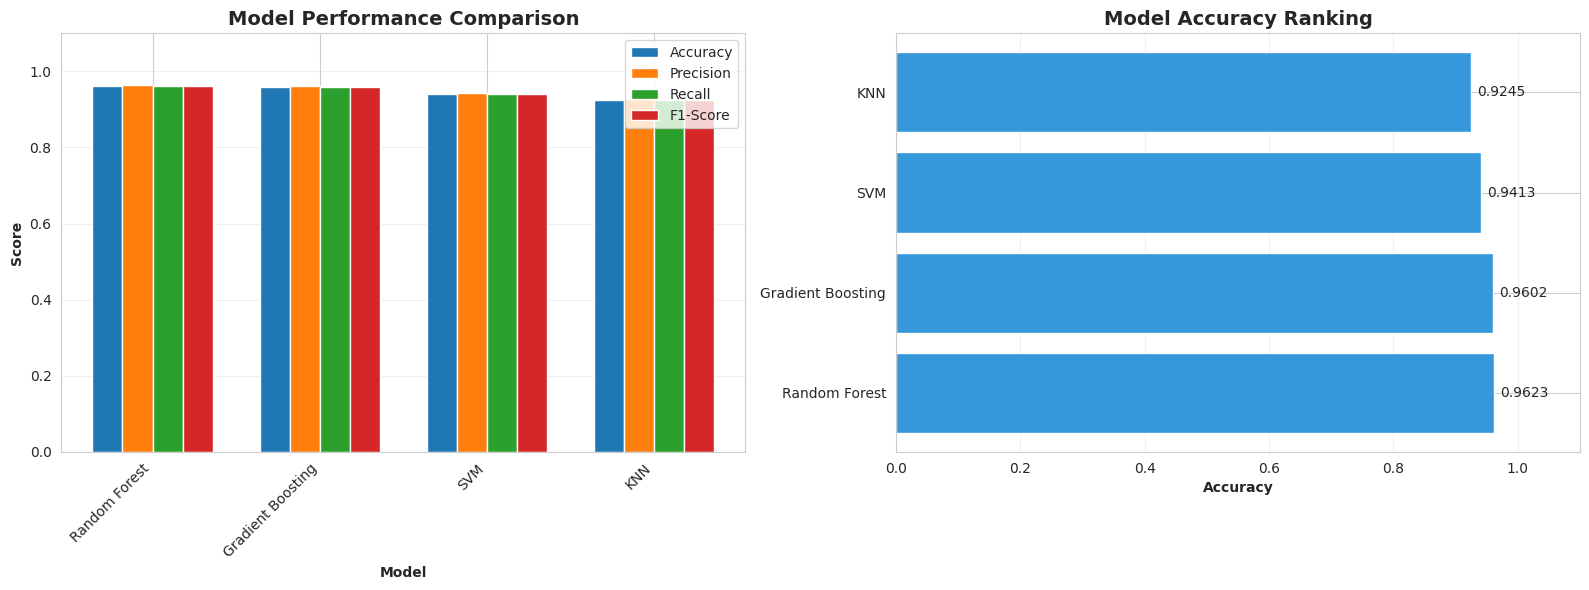

Saved: confusion_matrix_best_model.png


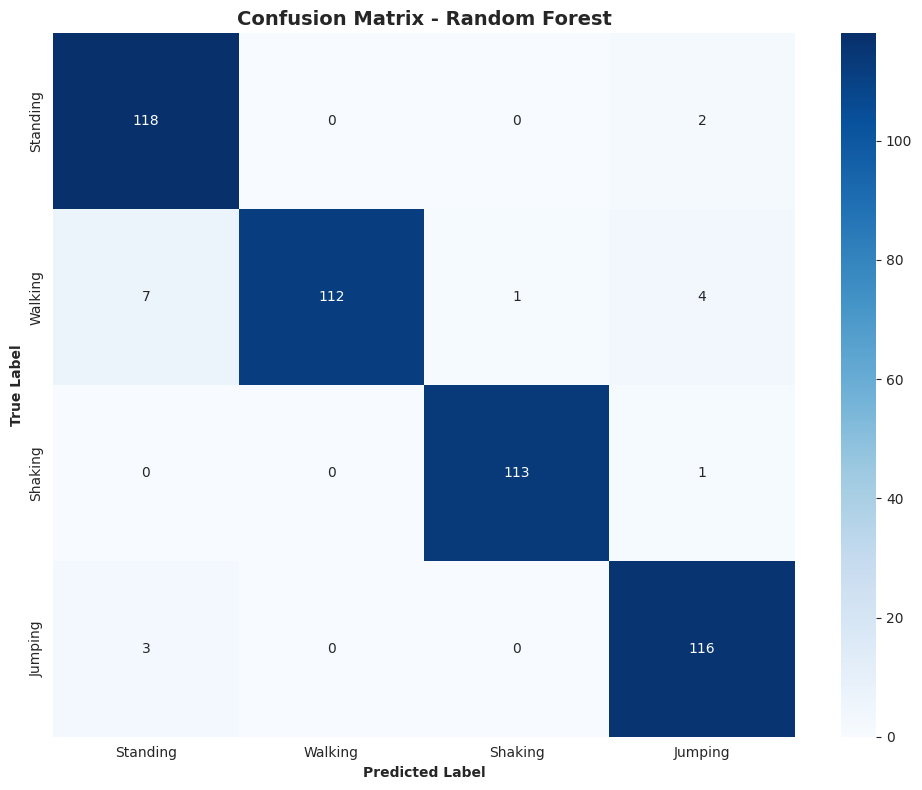


Detailed Classification Report - Random Forest:
              precision    recall  f1-score   support

    Standing       0.92      0.98      0.95       120
     Walking       1.00      0.90      0.95       124
     Shaking       0.99      0.99      0.99       114
     Jumping       0.94      0.97      0.96       119

    accuracy                           0.96       477
   macro avg       0.96      0.96      0.96       477
weighted avg       0.96      0.96      0.96       477

Saved: feature_importance.png


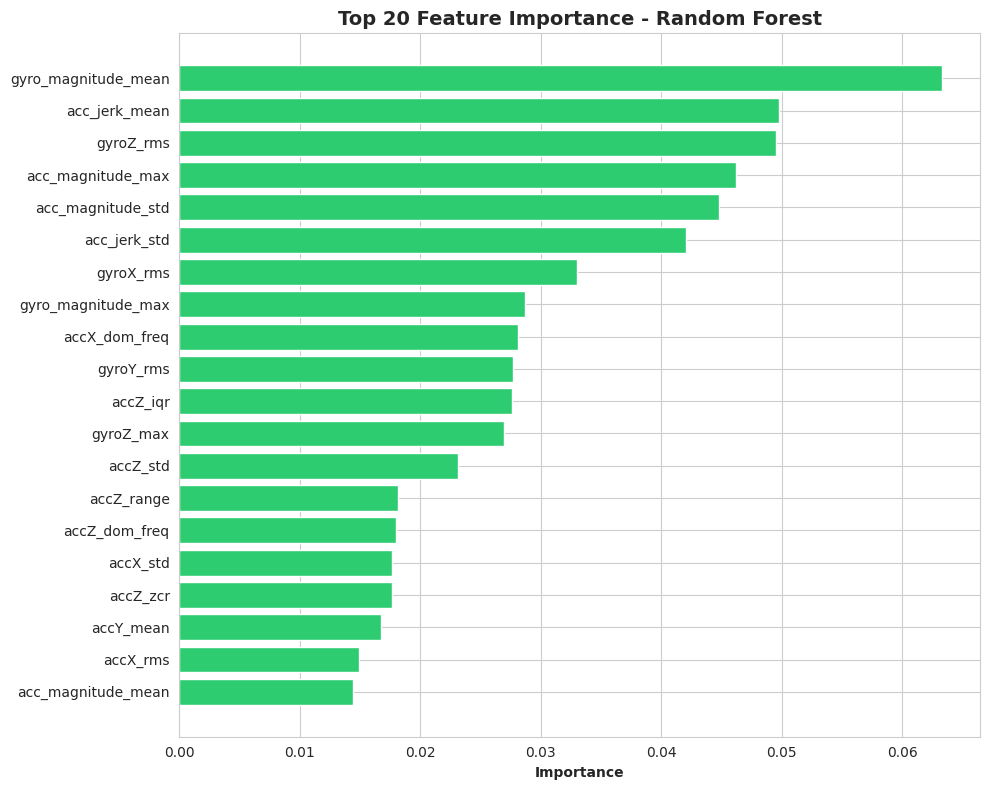

In [18]:
# comparison table
comparison_data = []
for model_name, results in models_results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

print("\nMODEL PERFORMANCE COMPARISON:")
print(comparison_df.to_string(index=False))

# Visualization of model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(comparison_df))
width = 0.18

for i, metric in enumerate(metrics):
    axes[0].bar(x + i*width, comparison_df[metric], width, label=metric)

axes[0].set_xlabel('Model', fontweight='bold')
axes[0].set_ylabel('Score', fontweight='bold')
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim([0, 1.1])
axes[0].grid(axis='y', alpha=0.3)

# Accuracy comparison
axes[1].barh(comparison_df['Model'], comparison_df['Accuracy'], color='#3498db')
axes[1].set_xlabel('Accuracy', fontweight='bold')
axes[1].set_title('Model Accuracy Ranking', fontsize=14, fontweight='bold')
axes[1].set_xlim([0, 1.1])
axes[1].grid(axis='x', alpha=0.3)

for i, v in enumerate(comparison_df['Accuracy']):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("\nSaved: model_comparison.png")
plt.show()

# Best model confusion matrix
best_model_name = comparison_df.iloc[0]['Model']
best_model_results = models_results[best_model_name]

fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_test, best_model_results['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Standing', 'Walking', 'Shaking', 'Jumping'],
            yticklabels=['Standing', 'Walking', 'Shaking', 'Jumping'])
ax.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontweight='bold')
ax.set_xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix_best_model.png', dpi=300, bbox_inches='tight')
print("Saved: confusion_matrix_best_model.png")
plt.show()

# Detailed classification report for best model
print(f"\nDetailed Classification Report - {best_model_name}:")
print(classification_report(y_test, best_model_results['predictions'],
                          target_names=['Standing', 'Walking', 'Shaking', 'Jumping']))

# Feature importance (for tree-based models)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    feature_importance = best_model_results['model'].feature_importances_
    feature_names = X.columns

    # Get top 20 features
    indices = np.argsort(feature_importance)[-20:]

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(range(len(indices)), feature_importance[indices], color='#2ecc71')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([feature_names[i] for i in indices])
    ax.set_xlabel('Importance', fontweight='bold')
    ax.set_title(f'Top 20 Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    print("Saved: feature_importance.png")
    plt.show()

# Anomaly Detection

In [19]:
print("Unique y_train values:", np.unique(y_train))
print("Unique y_test values:", np.unique(y_test))

Unique y_train values: ['Jumping' 'Shaking' 'Standing' 'Walking']
Unique y_test values: ['Jumping' 'Shaking' 'Standing' 'Walking']



 Training Isolation Forest
 Isolation Forest Accuracy: 0.3648

 Training One-Class SVM
One-Class SVM Accuracy: 0.8071

 Statistical Threshold-Based Anomaly Detection
Statistical Threshold Accuracy: 0.8008
ANOMALY DETECTION RESULTS:

ANOMALY DETECTION PERFORMANCE:
               Method  Accuracy  Precision   Recall  F1-Score
        One-Class SVM  0.807128   0.800443 0.994490  0.886978
Statistical Threshold  0.800839   0.985507 0.749311  0.851330
     Isolation Forest  0.364780   1.000000 0.165289  0.283688

 Saved: anomaly_detection_comparison.png


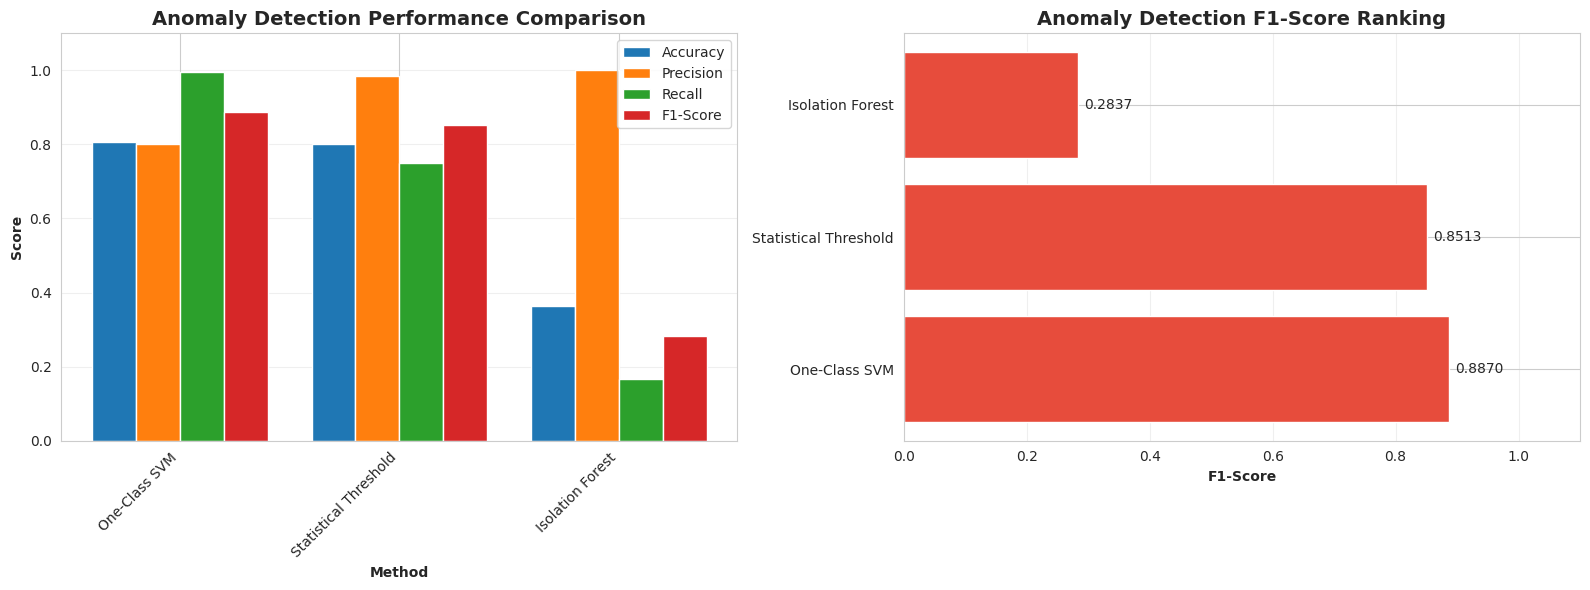

Saved: anomaly_confusion_matrices.png


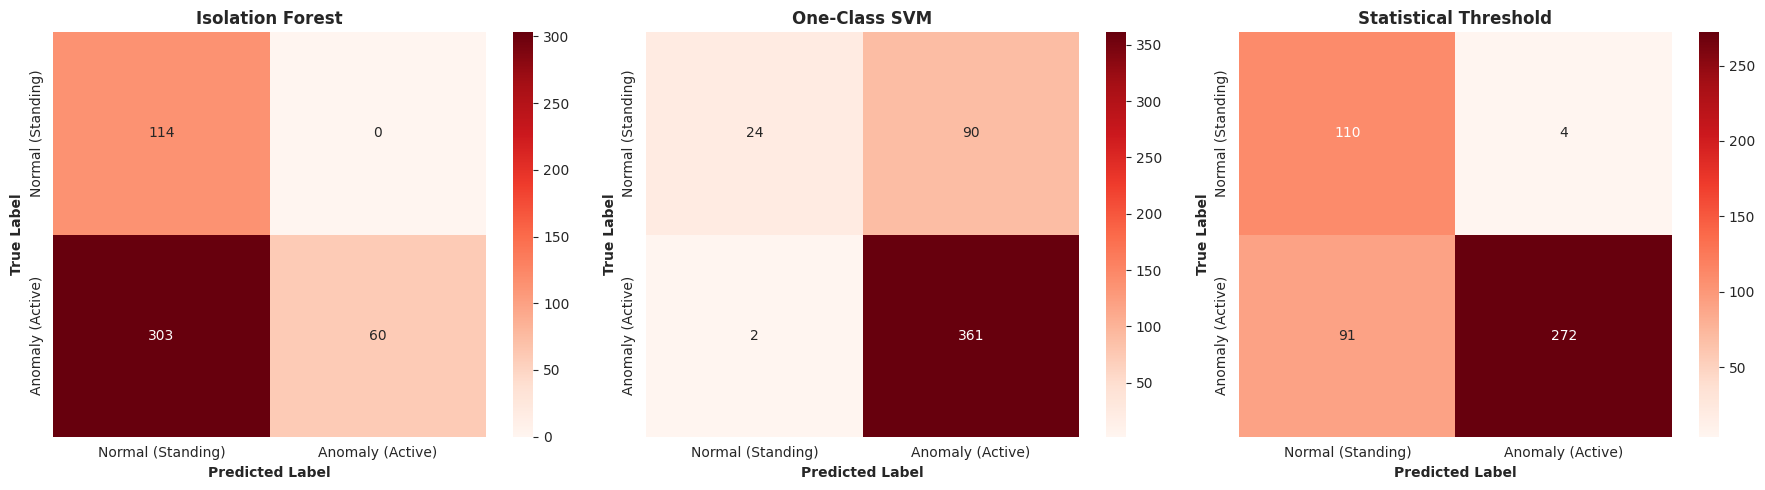

In [20]:
# Treating standing' (0) as normal behavior for dormancy detection
X_normal = X_train_scaled[y_train == 'Standing']  # Standing only
X_test_anomaly = X_test_scaled

# Creating labels: 0 = standing (normal), 1 = other activities (anomaly)
y_test_anomaly = (y_test != 'Standing').astype(int)

if X_normal.shape[0] == 0:
    raise ValueError("No Standing samples found in training data. Verify y_train labels.")

anomaly_results = {}

# Isolation Forest
print("\n Training Isolation Forest")
iso_forest = IsolationForest(contamination='auto', random_state=42, n_jobs=-1)
iso_forest.fit(X_train_scaled)  # Train on all data

# Predict (-1 for anomaly, 1 for normal)
iso_pred = iso_forest.predict(X_test_anomaly)
iso_pred_binary = (iso_pred == -1).astype(int)  # Convert to 0/1

iso_accuracy = accuracy_score(y_test_anomaly, iso_pred_binary)
anomaly_results['Isolation Forest'] = {
    'predictions': iso_pred_binary,
    'accuracy': iso_accuracy,
    'precision': precision_score(y_test_anomaly, iso_pred_binary, zero_division=0),
    'recall': recall_score(y_test_anomaly, iso_pred_binary, zero_division=0),
    'f1': f1_score(y_test_anomaly, iso_pred_binary, zero_division=0)
}

print(f" Isolation Forest Accuracy: {iso_accuracy:.4f}")

# One-Class SVM
print("\n Training One-Class SVM")
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.76)
oc_svm.fit(X_normal)  # Train only on standing data

# Predict (-1 for anomaly, 1 for normal)
oc_svm_pred = oc_svm.predict(X_test_anomaly)
oc_svm_pred_binary = (oc_svm_pred == -1).astype(int)

oc_svm_accuracy = accuracy_score(y_test_anomaly, oc_svm_pred_binary)
anomaly_results['One-Class SVM'] = {
    'predictions': oc_svm_pred_binary,
    'accuracy': oc_svm_accuracy,
    'precision': precision_score(y_test_anomaly, oc_svm_pred_binary, zero_division=0),
    'recall': recall_score(y_test_anomaly, oc_svm_pred_binary, zero_division=0),
    'f1': f1_score(y_test_anomaly, oc_svm_pred_binary, zero_division=0)
}

print(f"One-Class SVM Accuracy: {oc_svm_accuracy:.4f}")

# Statistical threshold-based approach
print("\n Statistical Threshold-Based Anomaly Detection")

# Calculate mean and std of acceleration magnitude for standing
standing_data = X_train_scaled[y_train == 'Standing']
acc_mag_idx = [i for i, col in enumerate(X.columns) if 'acc_magnitude' in col][0]
entropy_idx = [i for i, col in enumerate(X.columns) if col == 'accZ_spectral_entropy'][0]
mag_mean, mag_std = standing_data[:, acc_mag_idx].mean(), standing_data[:, acc_mag_idx].std()
entropy_mean, entropy_std = standing_data[:, entropy_idx].mean(), standing_data[:, entropy_idx].std()
threshold_mag = mag_mean + 2 * mag_std
threshold_entropy = entropy_mean + 2 * entropy_std


# Predict anomalies
stat_pred = ((X_test_anomaly[:, acc_mag_idx] > threshold_mag) |
             (X_test_anomaly[:, entropy_idx] > threshold_entropy)).astype(int)
stat_accuracy = accuracy_score(y_test_anomaly, stat_pred)

anomaly_results['Statistical Threshold'] = {
    'predictions': stat_pred,
    'accuracy': stat_accuracy,
    'precision': precision_score(y_test_anomaly, stat_pred, zero_division=0),
    'recall': recall_score(y_test_anomaly, stat_pred, zero_division=0),
    'f1': f1_score(y_test_anomaly, stat_pred, zero_division=0)
}

print(f"Statistical Threshold Accuracy: {stat_accuracy:.4f}")

# Anomaly detection comparison
print("ANOMALY DETECTION RESULTS:")


anomaly_comparison = []
for method_name, results in anomaly_results.items():
    anomaly_comparison.append({
        'Method': method_name,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1']
    })

anomaly_df = pd.DataFrame(anomaly_comparison)
anomaly_df = anomaly_df.sort_values('F1-Score', ascending=False)

print("\nANOMALY DETECTION PERFORMANCE:")
print(anomaly_df.to_string(index=False))

# Visualize anomaly detection results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(anomaly_df))
width = 0.2

for i, metric in enumerate(metrics):
    axes[0].bar(x + i*width, anomaly_df[metric], width, label=metric)

axes[0].set_xlabel('Method', fontweight='bold')
axes[0].set_ylabel('Score', fontweight='bold')
axes[0].set_title('Anomaly Detection Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(anomaly_df['Method'], rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim([0, 1.1])
axes[0].grid(axis='y', alpha=0.3)

# F1-Score ranking
axes[1].barh(anomaly_df['Method'], anomaly_df['F1-Score'], color='#e74c3c')
axes[1].set_xlabel('F1-Score', fontweight='bold')
axes[1].set_title('Anomaly Detection F1-Score Ranking', fontsize=14, fontweight='bold')
axes[1].set_xlim([0, 1.1])
axes[1].grid(axis='x', alpha=0.3)

for i, v in enumerate(anomaly_df['F1-Score']):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.savefig('anomaly_detection_comparison.png', dpi=300, bbox_inches='tight')
print("\n Saved: anomaly_detection_comparison.png")
plt.show()

# Confusion matrices for anomaly detection
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (method_name, results) in enumerate(anomaly_results.items()):
    cm = confusion_matrix(y_test_anomaly, results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=axes[idx],
                xticklabels=['Normal (Standing)', 'Anomaly (Active)'],
                yticklabels=['Normal (Standing)', 'Anomaly (Active)'])
    axes[idx].set_title(f'{method_name}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontweight='bold')

plt.tight_layout()
plt.savefig('anomaly_confusion_matrices.png', dpi=300, bbox_inches='tight')
print("Saved: anomaly_confusion_matrices.png")
plt.show()

# Classification Vs Anomaly Detection Comparison


Random Forest (Classification converted to binary):
  Accuracy:  0.7610
  Precision: 0.7610
  Recall:    1.0000
  F1-Score:  0.8643

Best Anomaly Detection Method (One-Class SVM):
  Accuracy:  0.8071
  Precision: 0.8004
  Recall:    0.9945
  F1-Score:  0.8870

 Saved: classification_vs_anomaly.png


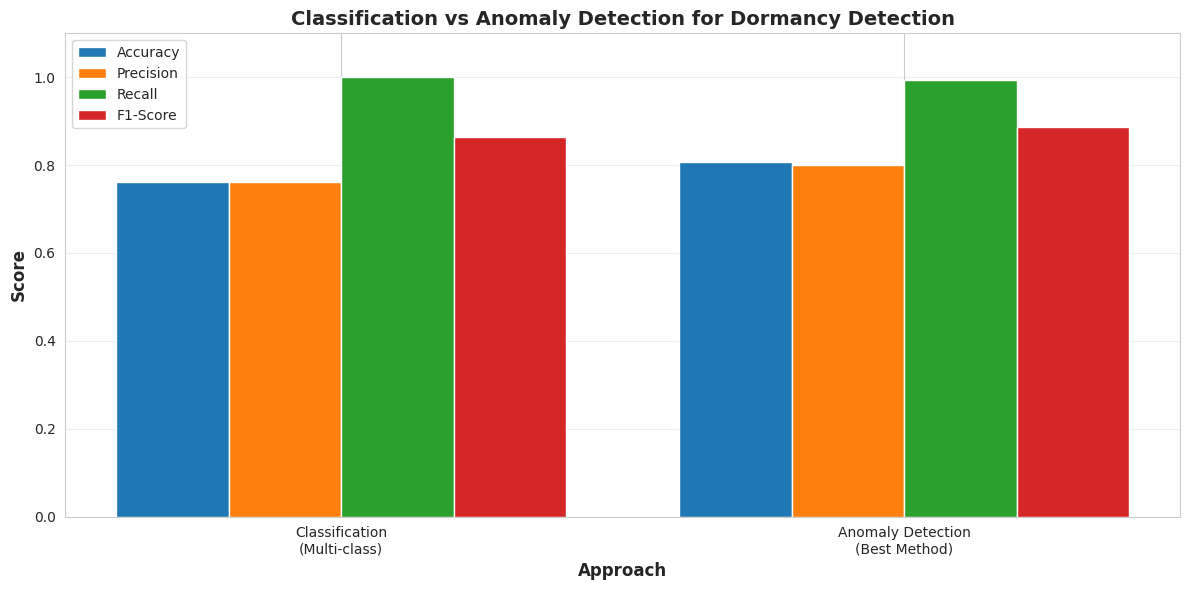

In [21]:
# Convert classification predictions to binary (standing vs not standing)
best_classification_pred = best_model_results['predictions']
best_classification_binary = (best_classification_pred != 0).astype(int)

# Calculate metrics for classification approach
classification_binary_metrics = {
    'accuracy': accuracy_score(y_test_anomaly, best_classification_binary),
    'precision': precision_score(y_test_anomaly, best_classification_binary, zero_division=0),
    'recall': recall_score(y_test_anomaly, best_classification_binary, zero_division=0),
    'f1': f1_score(y_test_anomaly, best_classification_binary, zero_division=0)
}

print(f"\n{best_model_name} (Classification converted to binary):")
print(f"  Accuracy:  {classification_binary_metrics['accuracy']:.4f}")
print(f"  Precision: {classification_binary_metrics['precision']:.4f}")
print(f"  Recall:    {classification_binary_metrics['recall']:.4f}")
print(f"  F1-Score:  {classification_binary_metrics['f1']:.4f}")

print(f"\nBest Anomaly Detection Method ({anomaly_df.iloc[0]['Method']}):")
best_anomaly = anomaly_df.iloc[0]
print(f"  Accuracy:  {best_anomaly['Accuracy']:.4f}")
print(f"  Precision: {best_anomaly['Precision']:.4f}")
print(f"  Recall:    {best_anomaly['Recall']:.4f}")
print(f"  F1-Score:  {best_anomaly['F1-Score']:.4f}")

# Create comparison visualization
fig, ax = plt.subplots(figsize=(12, 6))

approaches = ['Classification\n(Multi-class)', 'Anomaly Detection\n(Best Method)']
metrics_comparison = {
    'Accuracy': [classification_binary_metrics['accuracy'], best_anomaly['Accuracy']],
    'Precision': [classification_binary_metrics['precision'], best_anomaly['Precision']],
    'Recall': [classification_binary_metrics['recall'], best_anomaly['Recall']],
    'F1-Score': [classification_binary_metrics['f1'], best_anomaly['F1-Score']]
}

x = np.arange(len(approaches))
width = 0.2

for i, (metric, values) in enumerate(metrics_comparison.items()):
    ax.bar(x + i*width, values, width, label=metric)

ax.set_xlabel('Approach', fontweight='bold', fontsize=12)
ax.set_ylabel('Score', fontweight='bold', fontsize=12)
ax.set_title('Classification vs Anomaly Detection for Dormancy Detection',
             fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(approaches)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('classification_vs_anomaly.png', dpi=300, bbox_inches='tight')
print("\n Saved: classification_vs_anomaly.png")
plt.show()

# Model Export for Development

In [22]:
# Save the best models
import pickle
import json

# Define the target directory
save_dir = '/content/drive/MyDrive/Angaza - Capstone/model_artifacts'

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

print("\nExporting models and scalers to", save_dir, "...")

# Save classification model
clf_model_path = os.path.join(save_dir, 'best_classification_model.pkl')
try:
    with open(clf_model_path, 'wb') as f:
        pickle.dump(best_model_results['model'], f)
    print(f" Saved: {clf_model_path}")
except NameError as e:
    print(f"Error: best_model_results not defined - {e}")
    raise

# Save anomaly detection model
best_anomaly_method = anomaly_df.iloc[0]['Method']
anomaly_model_path = os.path.join(save_dir, 'anomaly_detection_model.pkl')
try:
    if best_anomaly_method == 'Isolation Forest':
        with open(anomaly_model_path, 'wb') as f:
            pickle.dump(iso_forest, f)
    elif best_anomaly_method == 'One-Class SVM':
        with open(anomaly_model_path, 'wb') as f:
            pickle.dump(oc_svm, f)
    print(f" Saved: {anomaly_model_path}")
except NameError as e:
    print(f"Error: Variables (iso_forest or oc_svm) not defined - {e}")
    raise

# Save scaler
scaler_path = os.path.join(save_dir, 'feature_scaler.pkl')
try:
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    print(f" Saved: {scaler_path}")
except NameError as e:
    print(f"Error: scaler not defined - {e}")
    raise

# Save feature names
feature_names_path = os.path.join(save_dir, 'feature_names.json')
try:
    with open(feature_names_path, 'w') as f:
        json.dump(X.columns.tolist(), f)
    print(f" Saved: {feature_names_path}")
except NameError as e:
    print(f"Error: X not defined - {e}")
    raise

# Save model metadata
metadata = {
    'best_classification_model': best_model_name,
    'classification_accuracy': float(best_model_results['accuracy']),
    'best_anomaly_model': best_anomaly_method,
    'anomaly_f1_score': float(best_anomaly['F1-Score']),
    'window_duration_seconds': window_duration.total_seconds(),  # 3.0
    'window_step_seconds': window_step.total_seconds(),  # 1.5
    'min_samples_per_window': min_samples_per_window,  # 5
    'sampling_rate_hz': 9.07,  # From extract_features
    'dormancy_threshold_minutes': 60,
    'activity_labels': activity_labels,
    'feature_count': len(X.columns),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'scaler_mean': scaler.mean_.tolist() if hasattr(scaler, 'mean_') else [],
    'scaler_std': scaler.scale_.tolist() if hasattr(scaler, 'scale_') else [],
    'activity_map': activity_map
}

metadata_path = os.path.join(save_dir, 'model_metadata.json')
try:
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f" Saved: {metadata_path}")
except NameError as e:
    print(f"Error: Variables (best_model_name, activity_labels, etc.) not defined - {e}")
    raise


Exporting models and scalers to /content/drive/MyDrive/Angaza - Capstone/model_artifacts ...
 Saved: /content/drive/MyDrive/Angaza - Capstone/model_artifacts/best_classification_model.pkl
 Saved: /content/drive/MyDrive/Angaza - Capstone/model_artifacts/anomaly_detection_model.pkl
 Saved: /content/drive/MyDrive/Angaza - Capstone/model_artifacts/feature_scaler.pkl
 Saved: /content/drive/MyDrive/Angaza - Capstone/model_artifacts/feature_names.json
 Saved: /content/drive/MyDrive/Angaza - Capstone/model_artifacts/model_metadata.json
